In [1]:
import pandas as pd

In [2]:
bioclimatic_data = pd.read_csv('PA-train-bioclimatic.csv')
merged_data = pd.read_csv('cluster_with_pollution_data.csv')

In [3]:
print(bioclimatic_data.columns)

Index(['surveyId', 'Bio1', 'Bio2', 'Bio3', 'Bio4', 'Bio5', 'Bio6', 'Bio7',
       'Bio8', 'Bio9', 'Bio10', 'Bio11', 'Bio12', 'Bio13', 'Bio14', 'Bio15',
       'Bio16', 'Bio17', 'Bio18', 'Bio19'],
      dtype='object')


# Particle Swarm Optimization

Selected Species ID: 6874
Species ID 6874 found in Cluster 10788.
Species in Cluster 10788: [30.0, 37.0, 51.0, 67.0, 69.0, 74.0, 76.0, 81.0, 82.0, 140.0, 141.0, 146.0, 148.0, 154.0, 164.0, 180.0, 192.0, 203.0, 216.0, 238.0, 245.0, 249.0, 252.0, 254.0, 262.0, 265.0, 267.0, 269.0, 271.0, 272.0, 305.0, 311.0, 320.0, 326.0, 340.0, 351.0, 354.0, 355.0, 365.0, 392.0, 400.0, 410.0, 413.0, 423.0, 436.0, 446.0, 449.0, 450.0, 461.0, 462.0, 476.0, 480.0, 491.0, 493.0, 494.0, 495.0, 509.0, 515.0, 522.0, 540.0, 544.0, 545.0, 553.0, 558.0, 559.0, 578.0, 581.0, 628.0, 633.0, 636.0, 639.0, 661.0, 687.0, 694.0, 701.0, 712.0, 715.0, 751.0, 752.0, 783.0, 787.0, 795.0, 812.0, 822.0, 838.0, 850.0, 857.0, 868.0, 876.0, 877.0, 886.0, 887.0, 893.0, 895.0, 902.0, 906.0, 908.0, 923.0, 944.0, 945.0, 949.0, 950.0, 960.0, 963.0, 976.0, 981.0, 982.0, 986.0, 996.0, 999.0, 1014.0, 1015.0, 1018.0, 1019.0, 1027.0, 1051.0, 1062.0, 1071.0, 1073.0, 1092.0, 1099.0, 1119.0, 1121.0, 1125.0, 1132.0, 1139.0, 1140.0, 1152.0, 11

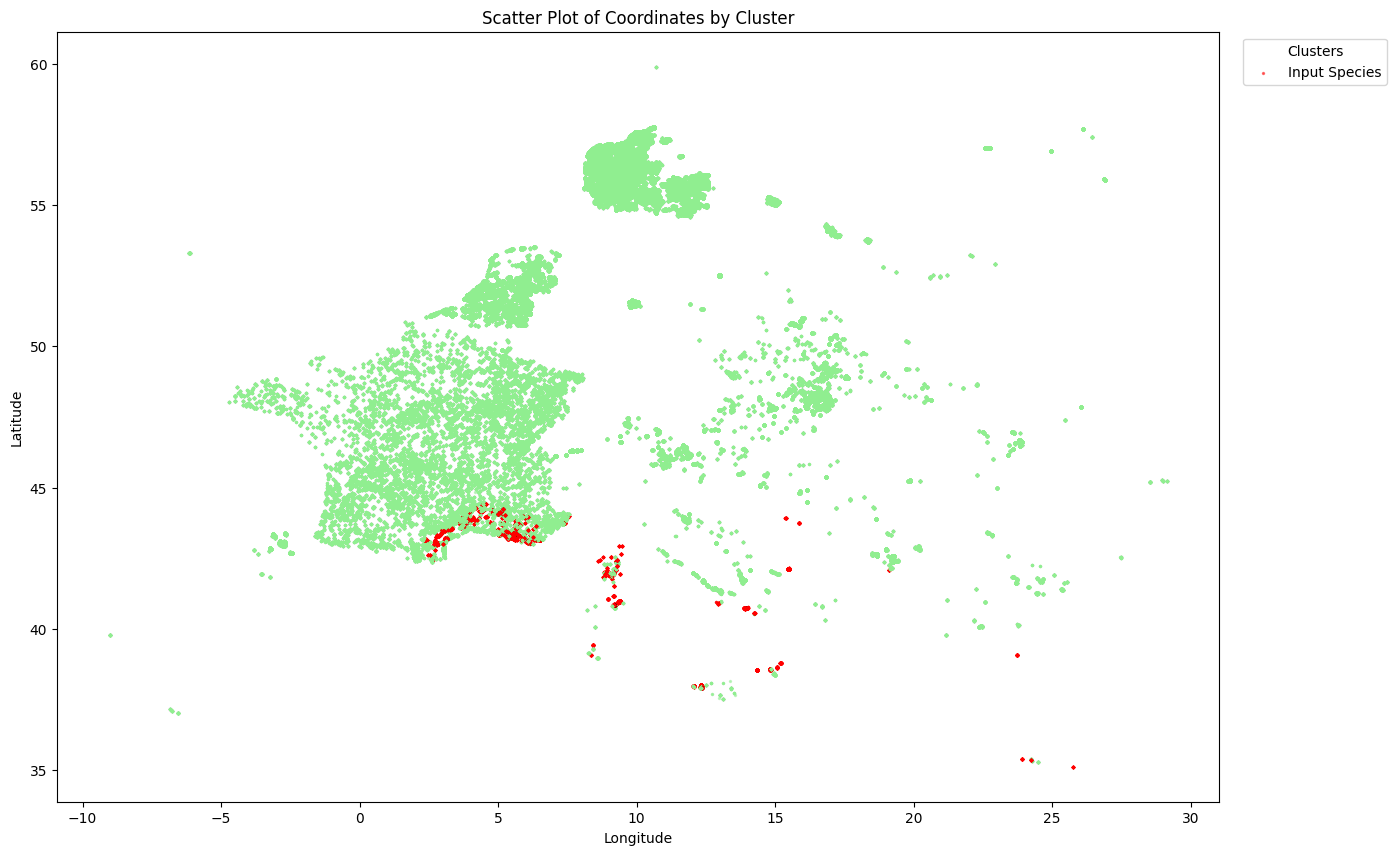

In [4]:
import pandas as pd
import ast  # To parse string representation of lists into actual lists
import matplotlib.pyplot as plt
import numpy as np
from pyswarm import pso
import random

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Load and preprocess data
def load_data():
    merged_data = pd.read_csv('cluster_with_pollution_data.csv')

    # Convert necessary columns from string representation of lists to actual lists
    merged_data['coordinates_lon'] = merged_data['coordinates_lon'].apply(ast.literal_eval)
    merged_data['coordinates_lat'] = merged_data['coordinates_lat'].apply(ast.literal_eval)
    merged_data['speciesId'] = merged_data['speciesId'].apply(ast.literal_eval)
    return merged_data

# Define a function to calculate the fitness of a cluster
def fitness_function(cluster, merged_data):
    # Extract relevant pollution data for the cluster
    cluster_data = merged_data[merged_data['cluster'] == cluster]
    
    # Calculate a score based on AQI and other pollutants (lower is better)
    score = 0
    if not cluster_data.empty:
        score += cluster_data['AQI'].mean() * 0.4  # Weight for AQI
        score += cluster_data['CO'].mean() * 0.2   # Weight for CO
        score += cluster_data['NO2'].mean() * 0.2  # Weight for NO2
        score += cluster_data['PM2.5'].mean() * 0.2 # Weight for PM2.5
    
    return score

# PSO function to optimize cluster selection
def optimize_clusters(merged_data):
    lb = [0]  # Lower boundary
    ub = [merged_data['cluster'].nunique() - 1]  # Upper boundary

    def objective_function(x):
        return fitness_function(int(x[0]), merged_data)

    best_cluster, best_score = pso(objective_function, lb, ub)

    return int(best_cluster), float(best_score)  # Return as scalar values

# Function to plot clusters and highlight specified species
def plot_clusters(df, input_species_id):
    plt.figure(figsize=(15, 10))

    found_species = False
    cluster_id_with_species = None
    all_species_in_cluster = set()

    for idx, row in df.iterrows():
        longitudes = row['coordinates_lon']
        latitudes = row['coordinates_lat']
        species_list = row['speciesId']
        
        # Check if the input species_id is in the species_list
        if input_species_id in species_list:
            plt.scatter(longitudes, latitudes, s=2, alpha=0.5, color='red', label='Input Species' if not found_species else "")
            found_species = True
            cluster_id_with_species = row['cluster']  # Record the cluster ID with the input species
            all_species_in_cluster.update(species_list)  # Collect all species in this cluster
        else:
            plt.scatter(longitudes, latitudes, s=2, alpha=0.5, color='lightgreen', label='Other Species' if idx == 0 else "")

    # If species ID is found, print the cluster number and all species in it
    if found_species:
        print(f"Species ID {input_species_id} found in Cluster {cluster_id_with_species}.")
        print(f"Species in Cluster {cluster_id_with_species}: {sorted(all_species_in_cluster)}")

    # If species ID is not found, recommend the next best cluster
    else:
        print(f"Species ID {input_species_id} not found. Recommending the next best cluster.")
        recommended_cluster, score = optimize_clusters(df)
        print(f"Recommended Cluster: {recommended_cluster}, Score: {score}")
        
        # Highlight the recommended cluster in blue
        recommended_cluster_data = df[df['cluster'] == recommended_cluster]
        all_species_in_cluster = set()

        for idx, row in recommended_cluster_data.iterrows():
            plt.scatter(row['coordinates_lon'], row['coordinates_lat'], s=5, alpha=0.5, color='blue', label='Recommended Cluster')
            all_species_in_cluster.update(row['speciesId'])  # Collect all species in this cluster

        # Print all species present in the recommended cluster
        print(f"Species in Recommended Cluster {recommended_cluster}: {sorted(all_species_in_cluster)}")

    plt.title('Scatter Plot of Coordinates by Cluster')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), title='Clusters')
    plt.show()

# Main function to load data and run plotting
def main():
    # Load data
    merged_data = load_data()

    # Get user input for species ID
    try:
        input_species_id = int(input("Enter the species ID to highlight: "))
    except ValueError:
        print("Invalid input. Please enter a numerical species ID.")
        return

    print(f"Selected Species ID: {input_species_id}")

    # Plot clusters and highlight the specified species
    plot_clusters(merged_data, input_species_id)

# Run the main function
if __name__ == "__main__":
    main()

In [5]:
def remove_species_from_cluster(df, cluster_id, species_id_to_remove):
    # Check if the cluster contains the species
    if cluster_id is None:
        print("No cluster ID provided to remove species from.")
        return df

    print(f"Attempting to remove Species ID {species_id_to_remove} from Cluster {cluster_id}.")

    # Define a function to remove the species ID from the list
    def remove_species(species_list):
        if isinstance(species_list, list) and species_id_to_remove in species_list:
            species_list.remove(species_id_to_remove)
        return species_list

    # Apply the removal function to the rows in the specified cluster
    df.loc[df['cluster'] == cluster_id, 'speciesId'] = df.loc[df['cluster'] == cluster_id, 'speciesId'].apply(remove_species)

    # Confirm the change
    if species_id_to_remove in df[df['cluster'] == cluster_id]['speciesId'].explode().unique():
        print(f"Error: Species ID {species_id_to_remove} still found in Cluster {cluster_id}.")
    else:
        print(f"Species ID {species_id_to_remove} successfully removed from Cluster {cluster_id}.")
    
    return df

# Example usage
# Assuming `merged_data` is the DataFrame with your data and `recommended_cluster` is the identified cluster from main code
species_id_to_remove = 6874  # Replace with the actual species ID you want to remove
cluster_id_to_modify = 4044  # Replace with the actual cluster ID if known

# Remove the species ID from the specified cluster
merged_data = remove_species_from_cluster(merged_data, cluster_id_to_modify, species_id_to_remove)


Attempting to remove Species ID 6874 from Cluster 4044.
Species ID 6874 successfully removed from Cluster 4044.


Selected Species ID: 6874
Species ID 6874 found in Cluster 10788.
Species in Cluster 10788: [30.0, 37.0, 51.0, 67.0, 69.0, 74.0, 76.0, 81.0, 82.0, 140.0, 141.0, 146.0, 148.0, 154.0, 164.0, 180.0, 192.0, 203.0, 216.0, 238.0, 245.0, 249.0, 252.0, 254.0, 262.0, 265.0, 267.0, 269.0, 271.0, 272.0, 305.0, 311.0, 320.0, 326.0, 340.0, 351.0, 354.0, 355.0, 365.0, 392.0, 400.0, 410.0, 413.0, 423.0, 436.0, 446.0, 449.0, 450.0, 461.0, 462.0, 476.0, 480.0, 491.0, 493.0, 494.0, 495.0, 509.0, 515.0, 522.0, 540.0, 544.0, 545.0, 553.0, 558.0, 559.0, 578.0, 581.0, 628.0, 633.0, 636.0, 639.0, 661.0, 687.0, 694.0, 701.0, 712.0, 715.0, 751.0, 752.0, 783.0, 787.0, 795.0, 812.0, 822.0, 838.0, 850.0, 857.0, 868.0, 876.0, 877.0, 886.0, 887.0, 893.0, 895.0, 902.0, 906.0, 908.0, 923.0, 944.0, 945.0, 949.0, 950.0, 960.0, 963.0, 976.0, 981.0, 982.0, 986.0, 996.0, 999.0, 1014.0, 1015.0, 1018.0, 1019.0, 1027.0, 1051.0, 1062.0, 1071.0, 1073.0, 1092.0, 1099.0, 1119.0, 1121.0, 1125.0, 1132.0, 1139.0, 1140.0, 1152.0, 11

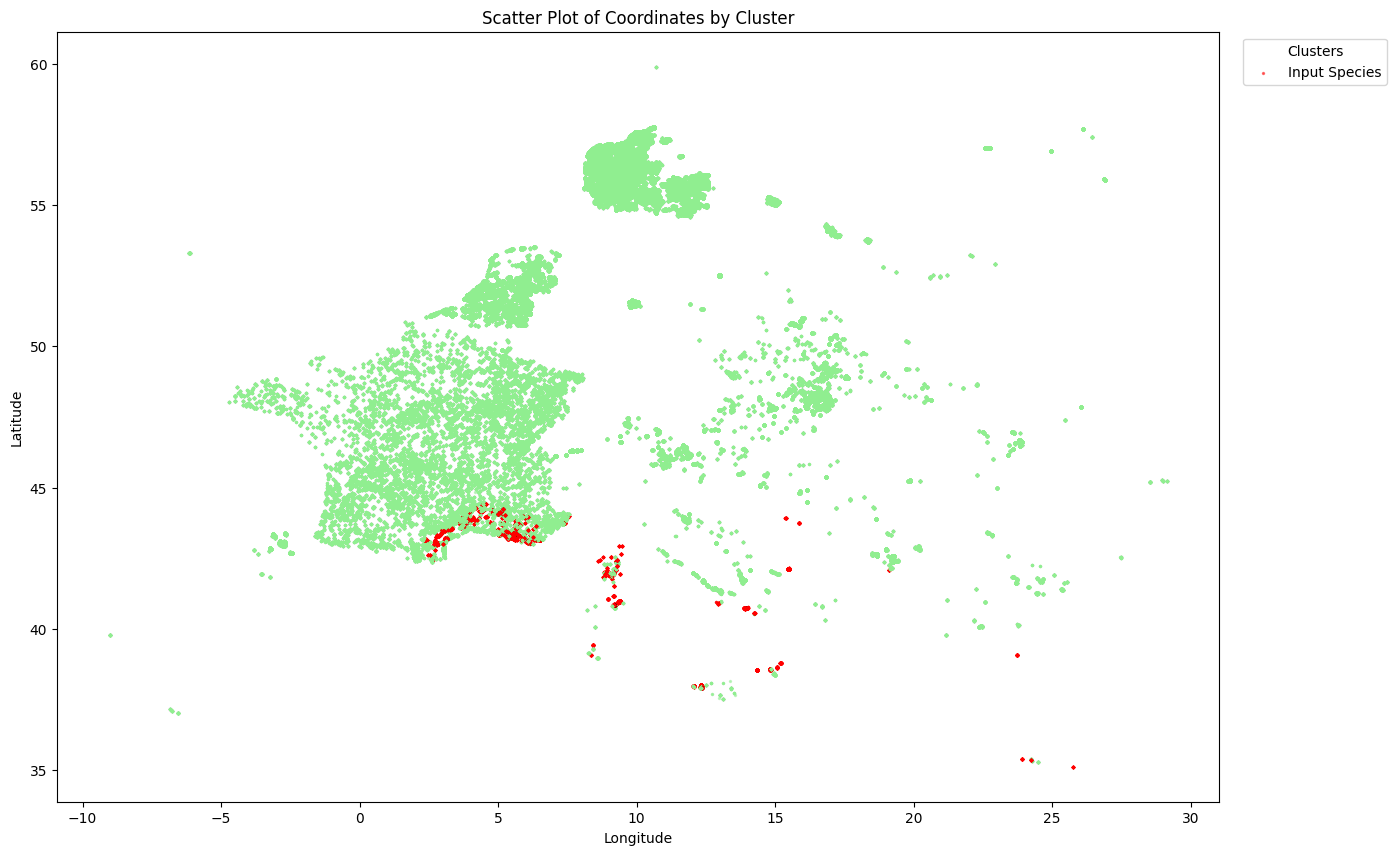

In [3]:
import pandas as pd
import ast  # To parse string representation of lists into actual lists
import matplotlib.pyplot as plt
import numpy as np
from ahpy import Compare  # For AHP
from sklearn.preprocessing import MinMaxScaler  # For normalization in TOPSIS

# Load and preprocess data
def load_data():
    merged_data = pd.read_csv('cluster_with_pollution_data.csv')
    merged_data['coordinates_lon'] = merged_data['coordinates_lon'].apply(ast.literal_eval)
    merged_data['coordinates_lat'] = merged_data['coordinates_lat'].apply(ast.literal_eval)
    merged_data['speciesId'] = merged_data['speciesId'].apply(ast.literal_eval)
    return merged_data

# Define a function to calculate criteria for each cluster
def calculate_criteria(df):
    # AQI Impact based on pollution data (e.g., AQI, CO, NO2, PM2.5)
    df['AQI_Impact'] = 0.4 * df['AQI'] + 0.2 * df['CO'] + 0.2 * df['NO2'] + 0.2 * df['PM2.5']
    
    # Species Importance as the count of unique species in each cluster
    df['Species_Importance'] = df['speciesId'].apply(lambda x: len(set(x)))
    
    # Tree Density based on the number of locations per cluster
    df['Tree_Density'] = df['coordinates_lon'].apply(len)
    return df

# Step 1: AHP to determine weights of criteria
def calculate_ahp_weights():
    criteria = {
        ('AQI_Impact', 'Species_Importance'): 3,
        ('AQI_Impact', 'Tree_Density'): 5,
        ('Species_Importance', 'Tree_Density'): 2,
    }
    comparison = Compare('Criteria', criteria, precision=3)
    weights = comparison.target_weights
    print("AHP Criteria Weights:", weights)
    print("Consistency Ratio:", comparison.consistency_ratio)
    return weights

# Step 2: TOPSIS - Rank clusters based on AHP weights
def topsis_ranking(df, weights):
    # Normalize the criteria
    scaler = MinMaxScaler()
    criteria_data = df[['AQI_Impact', 'Species_Importance', 'Tree_Density']]
    normalized_data = scaler.fit_transform(criteria_data)

    # Apply weights from AHP
    weighted_data = normalized_data * np.array(list(weights.values()))

    # Calculate ideal (best) and negative-ideal (worst) solutions
    ideal_solution = np.max(weighted_data, axis=0)
    negative_ideal_solution = np.min(weighted_data, axis=0)

    # Calculate distances to ideal and negative-ideal solutions
    dist_to_ideal = np.sqrt(np.sum((weighted_data - ideal_solution) ** 2, axis=1))
    dist_to_negative_ideal = np.sqrt(np.sum((weighted_data - negative_ideal_solution) ** 2, axis=1))

    # Calculate relative closeness to ideal solution
    topsis_score = dist_to_negative_ideal / (dist_to_ideal + dist_to_negative_ideal)
    df['TOPSIS_Score'] = topsis_score

    # Rank clusters based on TOPSIS score (higher score is closer to the ideal)
    ranked_df = df.sort_values(by='TOPSIS_Score', ascending=False)
    return ranked_df

# Function to plot clusters and highlight specified species
def plot_clusters(df, input_species_id):
    plt.figure(figsize=(15, 10))

    found_species = False
    cluster_id_with_species = None
    all_species_in_cluster = set()

    for idx, row in df.iterrows():
        longitudes = row['coordinates_lon']
        latitudes = row['coordinates_lat']
        species_list = row['speciesId']
        
        # Check if the input species_id is in the species_list
        if input_species_id in species_list:
            plt.scatter(longitudes, latitudes, s=2, alpha=0.5, color='red', label='Input Species' if not found_species else "")
            found_species = True
            cluster_id_with_species = row['cluster']  # Record the cluster ID with the input species
            all_species_in_cluster.update(species_list)  # Collect all species in this cluster
        else:
            plt.scatter(longitudes, latitudes, s=2, alpha=0.5, color='lightgreen', label='Other Species' if idx == 0 else "")

    # If species ID is found, print the cluster number and all species in it
    if found_species:
        print(f"Species ID {input_species_id} found in Cluster {cluster_id_with_species}.")
        print(f"Species in Cluster {cluster_id_with_species}: {sorted(all_species_in_cluster)}")

    # If species ID is not found, recommend the next best cluster
    else:
        print(f"Species ID {input_species_id} not found. Recommending the next best cluster.")
        recommended_cluster = topsis_ranking(df, calculate_ahp_weights()).iloc[0]
        print(f"Recommended Cluster: {recommended_cluster['cluster']}, Score: {recommended_cluster['TOPSIS_Score']}")
        
        # Highlight the recommended cluster in blue
        recommended_cluster_data = df[df['cluster'] == recommended_cluster['cluster']]
        all_species_in_cluster = set()

        for idx, row in recommended_cluster_data.iterrows():
            plt.scatter(row['coordinates_lon'], row['coordinates_lat'], s=5, alpha=0.5, color='blue', label='Recommended Cluster')
            all_species_in_cluster.update(row['speciesId'])  # Collect all species in this cluster

        # Print all species present in the recommended cluster
        print(f"Species in Recommended Cluster {recommended_cluster['cluster']}: {sorted(all_species_in_cluster)}")

    plt.title('Scatter Plot of Coordinates by Cluster')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), title='Clusters')
    plt.show()

# Main function to load data and run AHP + TOPSIS
def main():
    # Load and prepare data
    merged_data = load_data()
    merged_data = calculate_criteria(merged_data)

    # Get user input for species ID
    try:
        input_species_id = int(input("Enter the species ID to highlight: "))
    except ValueError:
        print("Invalid input. Please enter a numerical species ID.")
        return

    print(f"Selected Species ID: {input_species_id}")

    # Plot clusters and highlight the specified species
    plot_clusters(merged_data, input_species_id)

# Run the main function
if __name__ == "__main__":
    main()